# **DATA PREPROCESSING - Class 2**

>1.1 Dataset cleaning and Convertion of Dataset format from .csq to .parquet file

> 1.2 Defining the Classes and Reshaping the dataset for Logestic Regression model

## **Importing Required Libraries**

In [ ]:
!pip install tensorflow
!pip install psutil
!pip install joblib
!pip install scikit-learn
!pip install seaborn
!pip install matplotlib
!pip install pandas
!pip install numpy
!pip install tqdm
!matplotlib inline

In [1]:
import os
import sys
import gc
import numpy as np
import tensorflow as tf
import pandas as pd
import psutil
import shutil
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

## **Data Reshaping**

*   Defining Attack categories.
*   Importing the dataset and cleaning the imported data.
*   Reshaping the Dataset to meet the Logistic Regression model requirements.
*   Defining the required class and preprocessing the input dataset.
*   Saving the Preprocessed output as .npz file.





### **Defining Attack categories**

In [2]:
# Define attack categories
ATTACK_CATEGORIES_19   = {
    'ARP_Spoofing': 'Spoofing',
    'MQTT-DDoS-Connect_Flood': 'MQTT-DDoS-Connect_Flood',
    'MQTT-DDoS-Publish_Flood': 'MQTT-DDoS-Publish_Flood',
    'MQTT-DoS-Connect_Flood': 'MQTT-DoS-Connect_Flood',
    'MQTT-DoS-Publish_Flood': 'MQTT-DoS-Publish_Flood',
    'MQTT-Malformed_Data': 'MQTT-Malformed_Data',
    'Recon-OS_Scan': 'Recon-OS_Scan',
    'Recon-Ping_Sweep': 'Recon-Ping_Sweep',
    'Recon-Port_Scan': 'Recon-Port_Scan',
    'Recon-VulScan': 'Recon-VulScan',
    'TCP_IP-DDoS-ICMP': 'DDoS-ICMP',
    'TCP_IP-DDoS-SYN': 'DDoS-SYN',
    'TCP_IP-DDoS-TCP': 'DDoS-TCP',
    'TCP_IP-DDoS-UDP': 'DDoS-UDP',
    'TCP_IP-DoS-ICMP': 'DoS-ICMP',
    'TCP_IP-DoS-SYN': 'DoS-SYN',
    'TCP_IP-DoS-TCP': 'DoS-TCP',
    'TCP_IP-DoS-UDP': 'DoS-UDP',
    'Benign': 'Benign'
}

ATTACK_CATEGORIES_6 = {
    'Spoofing': 'Spoofing',
    'MQTT-DDoS-Connect_Flood': 'MQTT',
    'MQTT-DDoS-Publish_Flood': 'MQTT',
    'MQTT-DoS-Connect_Flood': 'MQTT',
    'MQTT-DoS-Publish_Flood': 'MQTT',
    'MQTT-Malformed_Data': 'MQTT',
    'Recon-OS_Scan': 'Recon',
    'Recon-Ping_Sweep': 'Recon',
    'Recon-Port_Scan': 'Recon',
    'Recon-VulScan': 'Recon',
    'DDoS-ICMP': 'DDoS',
    'DDoS-SYN': 'DDoS',
    'DDoS-TCP': 'DDoS',
    'DDoS-UDP': 'DDoS',
    'DoS-ICMP': 'DoS',
    'DoS-SYN': 'DoS',
    'DoS-TCP': 'DoS',
    'DoS-UDP': 'DoS',
    'Benign': 'Benign'
}

ATTACK_CATEGORIES_2 = {
    'ARP_Spoofing': 'attack',
    'MQTT-DDoS-Connect_Flood': 'attack',
    'MQTT-DDoS-Publish_Flood': 'attack',
    'MQTT-DoS-Connect_Flood': 'attack',
    'MQTT-DoS-Publish_Flood': 'attack',
    'MQTT-Malformed_Data': 'attack',
    'Recon-OS_Scan': 'attack',
    'Recon-Ping_Sweep': 'attack',
    'Recon-Port_Scan': 'attack',
    'Recon-VulScan': 'attack',
    'TCP_IP-DDoS-ICMP': 'attack',
    'TCP_IP-DDoS-SYN': 'attack',
    'TCP_IP-DDoS-TCP': 'attack',
    'TCP_IP-DDoS-UDP': 'attack',
    'TCP_IP-DoS-ICMP': 'attack',
    'TCP_IP-DoS-SYN': 'attack',
    'TCP_IP-DoS-TCP': 'attack',
    'TCP_IP-DoS-UDP': 'attack',
    'Benign': 'Benign'
}

###**Cleaning the imported data**

In [ ]:
# Data Cleaning Function
def clean_data(df):
    """Apply data cleaning procedures to the dataframe."""

    # Handle missing values (drop rows with >30% missing and fill remaining with median)
    df = df.dropna(thresh=int(0.7 * df.shape[1]))  # Drop rows with >30% missing
    df.fillna(df.median(numeric_only=True), inplace=True)

    return df

### **Feature Engineering**

In [ ]:
# Feature Engineering Function
def engineer_features(df):
    """Add or transform features to improve model input."""

    # Feature Engineering: log transform skewed numerical features
    for col in df.select_dtypes(include=np.number).columns:
        if df[col].skew() > 1:
            df[col] = np.log1p(df[col])

    # Add new features based on existing ones
    if 'packet_length' in df.columns and 'duration' in df.columns:
        df['bytes_per_sec'] = df['packet_length'] / (df['duration'] + 1e-5)
    if 'num_packets' in df.columns and 'duration' in df.columns:
        df['packet_rate'] = df['num_packets'] / (df['duration'] + 1e-5)

    # Drop unnecessary columns
    for col in ['session_id', 'timestamp']:
        if col in df.columns:
            df.drop(columns=[col], inplace=True)

    return df

### **Importing the dataset**

In [ ]:
#Input Directory path
data_dir = "<Enter the source converted dataset split path>"
# data_dir = '/content/drive/MyDrive/AI_and_sustainability/AI_and_Sus_Final/Dataset'

# Save Path
save_path = "<Enter the save path>"
# save_path = "/content/drive/MyDrive/AI_and_sustainability/AI_and_Sus_Final/Models_and_Result/Class_2/Preprocessed data/preprocessed_logistic_data2.npz"

### **Preprocessing  based on Logistic Regression model**

In [ ]:
# Selecting the class
class_config = 2

# Attack Category Mapping Function
def get_attack_category(file_name, class_config):
    if class_config == 2:
        categories = ATTACK_CATEGORIES_2
    elif class_config == 6:
        categories = ATTACK_CATEGORIES_6
    else:
        categories = ATTACK_CATEGORIES_19
    for key in categories:
        if key in file_name:
            return categories[key]
    return "Unknown"

# Main Preprocessing Function
def load_and_preprocess_data_optimized(data_dir, class_config):
    train_path = os.path.join(data_dir, "train")
    test_path = os.path.join(data_dir, "test")

    train_files = [os.path.join(train_path, f) for f in os.listdir(train_path) if f.endswith('.parquet')]
    test_files = [os.path.join(test_path, f) for f in os.listdir(test_path) if f.endswith('.parquet')]

    if not train_files or not test_files:
        raise FileNotFoundError("Missing .parquet files in train or test directories.")

    print(f"Found {len(train_files)} train files, {len(test_files)} test files.")

    X_train_list, y_train_list = [], []
    X_test_list, y_test_list = [], []

    def process_files(file_list, target_X, target_y, desc=""):
        for file in tqdm(file_list, desc=desc):
            df = pd.read_parquet(file)
            label = get_attack_category(file, class_config)
            if label == "Unknown":
                continue

            # Clean the data
            df = clean_data(df)  # Clean the data (missing values)

            # Apply feature engineering
            df = engineer_features(df)  # Perform feature engineering (new features, log transform)

            df['label'] = label
            y = df.pop('label')
            target_X.append(df.values)
            target_y.append([label] * len(df))
            del df

    process_files(train_files, X_train_list, y_train_list, desc="Processing Train")
    process_files(test_files, X_test_list, y_test_list, desc="Processing Test")

    X_train = np.vstack(X_train_list)
    y_train = np.concatenate(y_train_list)
    X_test = np.vstack(X_test_list)
    y_test = np.concatenate(y_test_list)

    del X_train_list, y_train_list, X_test_list, y_test_list

    # Lable Encoding
    print("Encoding labels...")
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)

    y_train_categorical = to_categorical(y_train_encoded)
    y_test_categorical = to_categorical(y_test_encoded)

    # Splitting and Scaling the Train and Test Split
    print("Splitting and scaling...")
    X_train, X_val, y_train_categorical, y_val_categorical = train_test_split(
        X_train, y_train_categorical, test_size=0.2, random_state=42
    )

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    #Saving the preprocessed data
    print("Saving preprocessed data...")

    np.savez_compressed(save_path,
                        X_train1=X_train, X_val1=X_val, X_test1=X_test,
                        y_train=y_train_categorical, y_val=y_val_categorical,
                        y_test=y_test_categorical, label_classes=label_encoder.classes_)

    print(f"Data saved to:\n- Logistic Regression: {save_path}")
    gc.collect()

load_and_preprocess_data_optimized(data_dir, class_config)

Found 51 train files, 21 test files.


Processing Test: 100%|██████████| 21/21 [00:07<00:00,  2.97it/s]


Encoding labels...
Splitting and scaling...
Saving preprocessed data...
Data saved to:
- Logistic Regression: /content/drive/MyDrive/AI_and_sustainability/AI_and_Sus_Final/Models_and_Result/Class_2/Preprocessed data/preprocessed_logistic_data2.npz


### **Lable Distrubtion Visualiation**

In [ ]:
# Label distribution visualization function (keep this in your utility section)
def plot_label_distribution(y_train_encoded, encoder):
    label_names = encoder.inverse_transform(y_train_encoded)
    sns.countplot(x=label_names)
    plt.title("Label Distribution (Training Set- Class 2)")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


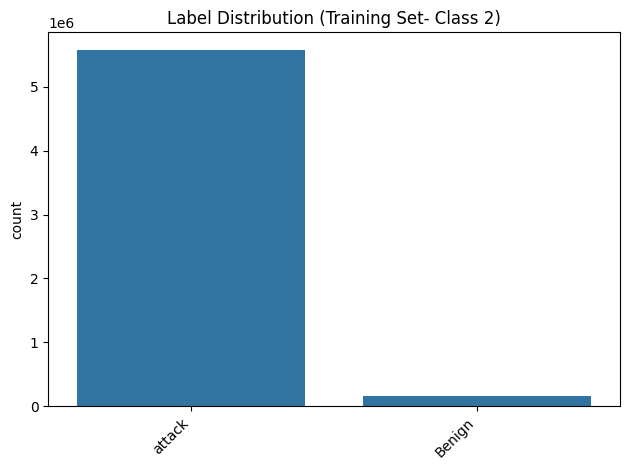

In [ ]:
# Load the preprocessed data and label encoder
data = np.load(save_path, allow_pickle=True)

# Decode the labels back from categorical
y_train_categorical = data['y_train']
label_encoder_classes = data['label_classes']

# Convert one-hot to integer labels
y_train_encoded = np.argmax(y_train_categorical, axis=1)

# Reconstruct the label encoder
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.classes_ = label_encoder_classes

# Call the visualization function
plot_label_distribution(y_train_encoded, label_encoder)
